# **Preprocessing, Feature Engineering, Feature Selection**

In [ ]:
import pandas as pd

df = pd.read_csv("AAPL.csv", skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].set_index('Date')
df = df.loc['2011-01-01':'2024-12-31']

**Lags**

In [ ]:
df['Close_lag1'] = df['Close'].shift(1)  # Yesterday’s closing price
df['Close_lag5'] = df['Close'].shift(5)  # Last week's closing price
df['Close_lag21'] = df['Close'].shift(21)  # Last month's closing price
df['Close_lag63'] = df['Close'].shift(63)  # Quarter's closing price

df['Volume_lag1'] = df['Volume'].shift(1)  # Volume from 1 days ago
df['Volume_lag5'] = df['Volume'].shift(5)  # Volume from 5 days ago
df['Volume_lag21'] = df['Volume'].shift(21)  # Volume from 21 days ago
df['Volume_lag63'] = df['Volume'].shift(63)  # Volume from 63 days ago

**Returns**

In [ ]:
df['return_1d'] = df['Close_lag1'].pct_change()         # Daily return
df['return_5d'] = df['Close_lag1'].pct_change(5)        # 5-day return
df['return_21d'] = df['Close_lag1'].pct_change(21)      # 21-day return
df['return_63d'] = df['Close_lag1'].pct_change(63)      # 63-day return


**Moving Averages**

In [ ]:
df['ma_5'] = df['Close_lag1'].rolling(window=5).mean()
df['ma_21'] = df['Close_lag1'].rolling(window=21).mean()
df['ma_63'] = df['Close_lag1'].rolling(window=63).mean()

**Volatility**

In [ ]:
df['volatility_5'] = df['Close_lag1'].rolling(window=5).std()
df['volatility_21'] = df['Close_lag1'].rolling(window=21).std()
df['volatility_63'] = df['Close_lag1'].rolling(window=63).std()

**Momentum**

In [ ]:
df['momentum_5'] = df['Close_lag1'] - df['Close_lag1'].shift(5)
df['momentum_21'] = df['Close_lag1'] - df['Close_lag1'].shift(21)
df['momentum_63'] = df['Close_lag1'] - df['Close_lag1'].shift(63)

# Transforming OHLC

In [ ]:
df['intraday_range'] = df['High'].shift(1) - df['Low'].shift(1)
df['gap'] = df['Open'].shift(1) - df['Close_lag1'].shift(1)
df['intraday_change'] = df['Close'].shift(1) - df['Open'].shift(1)
df['upper_shadow'] = df['High'].shift(1) - df[['Open', 'Close']].shift(1).max(axis=1)
df['lower_shadow'] = df[['Open', 'Close']].shift(1).min(axis=1) - df['Low'].shift(1)
df['edit_out'] = df['Close'] * [-1]

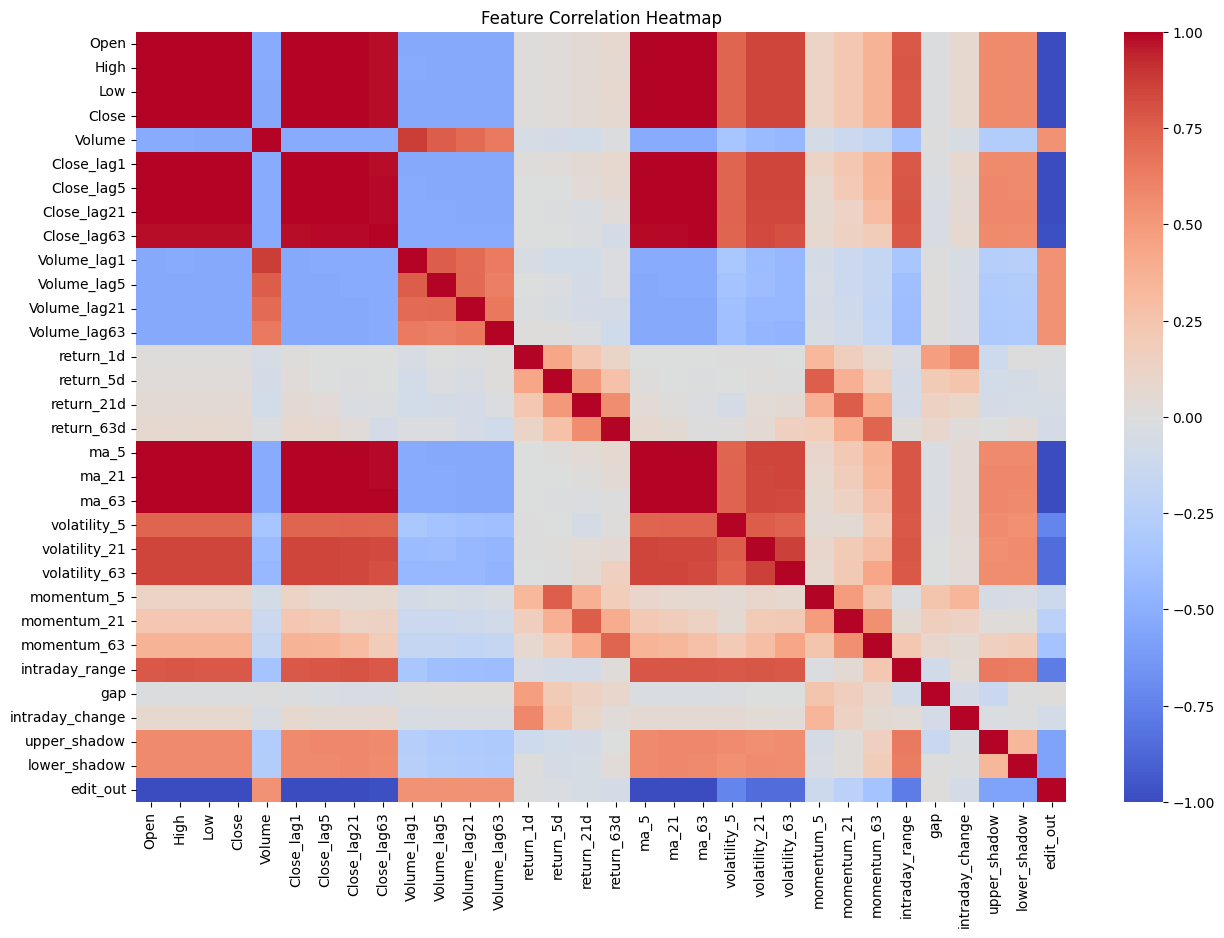

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.dropna().corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


return can go. gap and intaday change can go. volume lag and volume are basically same so volume lags go. OHLC are all very correlated. momentum is weak but 63 is getting better. maybe try higher?

close_lags and ma are all basically the same. go with low ma.

In [ ]:
df = df.drop(columns=['return_1d', 'return_5d', 'return_21d', 'return_63d', 'gap', 'intraday_change']) \
       .drop(columns=['Volume', 'Volume_lag5', 'Volume_lag21', 'Volume_lag63']) \
       .drop(columns=['momentum_5', 'momentum_21', 'momentum_63', 'volatility_5', 'volatility_21']) \
       .drop(columns=['Close_lag5', 'Close_lag21', 'Close_lag63', 'ma_21', 'ma_63'])

df['momentum_126'] = df['Close'] - df['Close'].shift(126)

In [ ]:
df = df.drop(columns=['edit_out'])

In [ ]:
df['edit_out'] = df['Close'] * [-1]

In [ ]:
df = df.drop(columns=['Open', 'High', 'Low'])

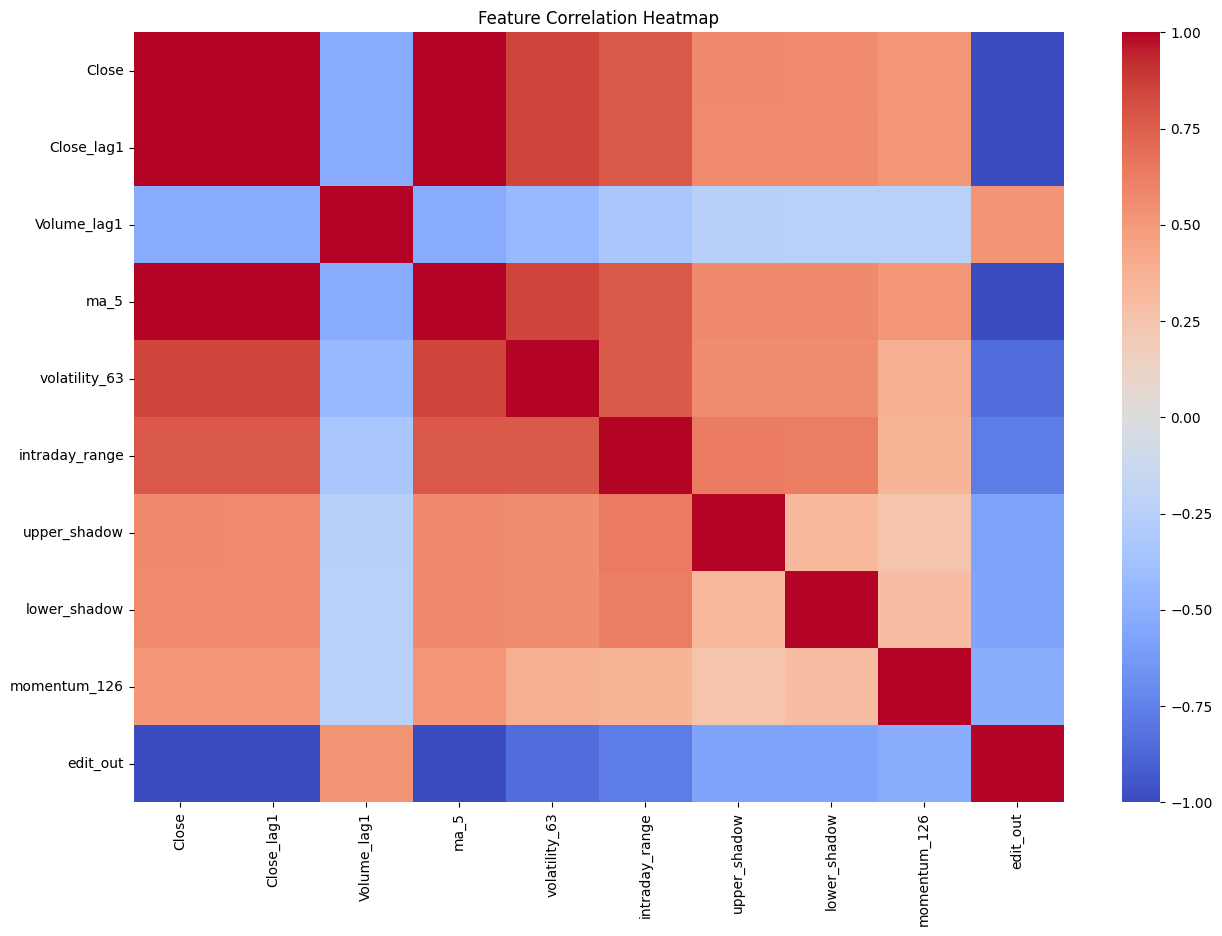

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.dropna().corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

features = df.drop(columns=['Close']).dropna()
target = df['Close'].dropna()
aligned_index = features.index.intersection(target.index)
X = features.loc[aligned_index]
y = target.loc[aligned_index]

X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=False, test_size=0.2)

model = RandomForestRegressor()
model.fit(X_train, y_train)
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances.head(20))


Close_lag1        0.606068
ma_5              0.393101
momentum_126      0.000434
volatility_63     0.000101
lower_shadow      0.000084
upper_shadow      0.000075
Volume_lag1       0.000075
intraday_range    0.000063
dtype: float64


In [ ]:
df = df.drop(columns=['edit_out'])

In [ ]:
# Input shape: (num_samples, time_steps, num_features)
# Select features based on above importance rankings

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df.dropna())

X_lstm = []
y_lstm = []
time_steps = 20  # e.g., 20 days of history

for i in range(time_steps, len(df_scaled)):
    X_lstm.append(df_scaled[i-time_steps:i])
    y_lstm.append(df['Close'].values[i])

import numpy as np
X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# New scaler just for target
close_scaler = MinMaxScaler()

y_train = y_train.reshape(-1, 1)
y_test_all = y_test_all.reshape(-1, 1)

y_train_scaled = close_scaler.fit_transform(y_train)
y_test_scaled = close_scaler.transform(y_test_all)

In [ ]:
dates = df.dropna().index[time_steps:]  # Align with X_lstm and y_lstm
X_lstm = X_lstm[:len(dates)]
y_lstm = y_lstm[:len(dates)]

train_mask = (dates >= '2012-01-01') & (dates <= '2014-12-31')
test_mask = (dates >= '2015-01-01') & (dates <= '2015-12-31')

X_train = X_lstm[train_mask]
y_train = y_lstm[train_mask]
X_test_all = X_lstm[test_mask]
y_test_all = y_lstm[test_mask]
dates_test = dates[test_mask]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(time_steps, X_train.shape[2])),
    Dropout(0.2),
    Dense(1)  # Predict next closing price
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train_scaled, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1574 - val_loss: 0.1408
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0690 - val_loss: 0.1354
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0654 - val_loss: 0.1199
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0712 - val_loss: 0.1385
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0681 - val_loss: 0.1469
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0665 - val_loss: 0.0998
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0648 - val_loss: 0.1047
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0666 - val_loss: 0.1095
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0659 - val_loss: 0.1201
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0624 - val_loss: 0.1173
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0614 - val_loss: 0.1181
Epoch 12/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0646 - val_l

In [ ]:
def recursive_predict(model, X_test_all, steps=5):
    predictions = []
    i = 0
    while i + steps <= len(X_test_all):
        input_seq = X_test_all[i].copy()  # shape: (time_steps, num_features)
        # Inside the while loop, after `input_seq = ...`

    # Optionally, print the actual `input_seq` and the first `pred_scaled`
        preds = []
        for _ in range(steps):
            input_seq_reshaped = input_seq.reshape(1, time_steps, -1)
            next_pred = model.predict(input_seq_reshaped, verbose=0)[0][0]
            preds.append(next_pred)

            # Replace last row with predicted Close (only the Close value is changing here)
            # Assuming Close is at index 3 in your feature list, for example
            next_input = input_seq[-1].copy()
            next_input[3] = scaler.transform([[0]*3 + [next_pred] + [0]*(input_seq.shape[1]-4)])[0][3]  # simple logic, adjust as needed
            input_seq = np.vstack([input_seq[1:], next_input])

        predictions.extend(preds)
        i += steps
    return predictions


In [ ]:
def inverse_close_scale(preds_scaled, scaler, close_index=1, feature_names=None):
    if feature_names is None:
        feature_names = scaler.feature_names_in_

    # Create a DataFrame with zeros and insert predictions in the 'Close' column
    dummy = pd.DataFrame(0, index=range(len(preds_scaled)), columns=feature_names)
    dummy.iloc[:, close_index] = preds_scaled

    inversed = scaler.inverse_transform(dummy)
    return inversed[:, close_index]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/valida

Test RMSE: 7.6588
Test MAE:  7.5097
Test R2:   -5.9543
Test MAPE: 0.3038


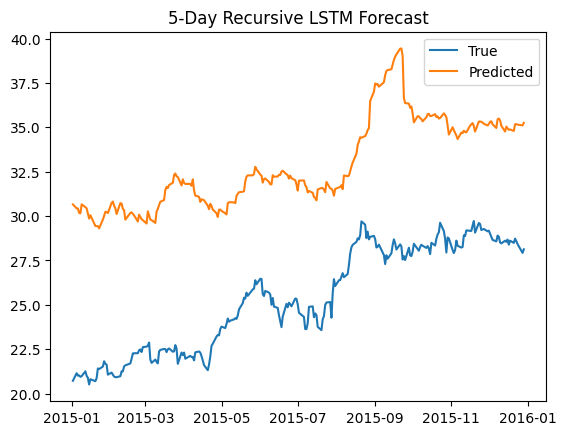

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

y_pred_scaled = recursive_predict(model, X_test_all, steps=5)
y_pred_scaled = np.array(y_pred_scaled) # Convert list to numpy array

# Fit the close_scaler on the true test data before inverse transforming
close_scaler.fit(y_test_all.reshape(-1, 1))

y_pred = close_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_true = y_test_all[:len(y_pred)]

# Evaluation
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test R2:   {r2:.4f}")
print(f"Test MAPE: {mape:.4f}")

plt.plot(dates_test[:len(y_pred)], y_true, label='True')
plt.plot(dates_test[:len(y_pred)], y_pred, label='Predicted')
plt.legend()
plt.title("5-Day Recursive LSTM Forecast")
plt.show()

In [ ]:
df.head()

,Close,Close_lag1,Volume_lag1,ma_5,volatility_63,intraday_range,upper_shadow,lower_shadow,momentum_126
Date,,,,,,,,,
2011-01-03,9.917947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-04,9.969708,9.917947,445138400.0,NaN,NaN,0.163107,0.020765,0.024075,NaN
2011-01-05,10.051258,9.969708,309080800.0,NaN,NaN,0.130907,0.001806,0.094494,NaN
2011-01-06,10.043139,10.051258,255519600.0,NaN,NaN,0.145653,0.010232,0.001505,NaN
2011-01-07,10.115063,10.043139,300428800.0,NaN,NaN,0.070720,0.015950,0.024978,NaN


In [ ]:
def anchored_recursive_predict(model, full_scaled_data, close_scaler, dates_all, start_date, end_date,
                               time_steps=20, steps=5, close_idx=3):

    def find_closest_date_index(dates, target_date, direction='forward'):
        if direction == 'forward':
            candidates = np.where(dates >= target_date)[0]
        else:
            candidates = np.where(dates <= target_date)[0]
        if len(candidates) == 0:
            return None
        return candidates[0] if direction == 'forward' else candidates[-1]

    start_idx = find_closest_date_index(dates_all, start_date, direction='forward')
    end_idx = find_closest_date_index(dates_all, end_date, direction='backward')

    if start_idx is None or end_idx is None:
        raise ValueError("Start or end date outside of date range in dataset")

    preds_all = []
    pred_dates_all = []

    i = start_idx
    while i + steps <= end_idx:
        if i - time_steps < 0:
            i += steps
            continue

        input_seq = full_scaled_data[i - time_steps:i].copy()
        # Inside the while loop, after `input_seq = ...`
        if i < start_idx + 2 * steps: # Print for first few blocks
          print(f"\n--- Block starting at date: {dates_all[i]} (index: {i}) ---")
          print(f"Input sequence dates (last {time_steps} days): {dates_all[i - time_steps]} to {dates_all[i-1]}")
          print(f"Prediction dates for this block: {dates_all[i]} to {dates_all[i+steps-1]}")
    # Optionally, print the actual `input_seq` and the first `pred_scaled`

        preds = []
        for step in range(steps):
            input_reshaped = input_seq.reshape(1, time_steps, -1)
            pred_scaled = model.predict(input_reshaped, verbose=0)[0][0]
            preds.append(pred_scaled)

            next_input = input_seq[-1].copy()
            next_input[close_idx] = pred_scaled
            input_seq = np.vstack([input_seq[1:], next_input])

        preds_all.extend(preds)
        pred_dates_all.extend(dates_all[i:i+steps])

        i += steps

    y_pred = close_scaler.inverse_transform(np.array(preds_all).reshape(-1, 1)).flatten()
    return y_pred, pred_dates_all



--- Block starting at date: 2015-01-02 00:00:00 (index: 880) ---
Input sequence dates (last 20 days): 2014-12-03 00:00:00 to 2014-12-31 00:00:00
Prediction dates for this block: 2015-01-02 00:00:00 to 2015-01-08 00:00:00

--- Block starting at date: 2015-01-09 00:00:00 (index: 885) ---
Input sequence dates (last 20 days): 2014-12-10 00:00:00 to 2015-01-08 00:00:00
Prediction dates for this block: 2015-01-09 00:00:00 to 2015-01-15 00:00:00
Anchored 5-day forecast metrics:
  RMSE: 361.3237
  MAE:  355.1703
  R2:   -47706.9592
  MAPE: 13.2822


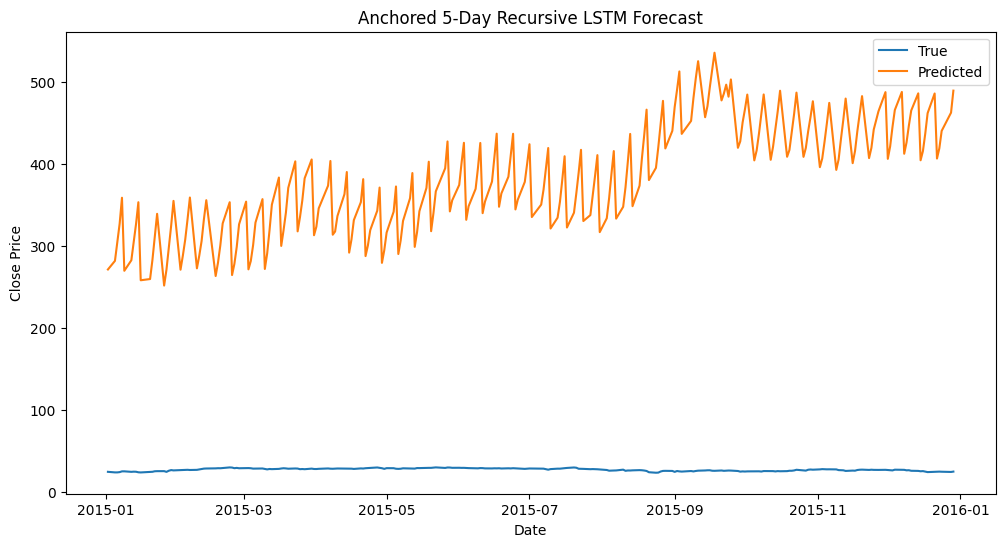

In [ ]:
# Use the same scaler and close_scaler you already fit
full_scaled_data = df_scaled  # scaled features for entire dataset, aligned with df.index
dates_all = df.dropna().index  # should match full_scaled_data rows

start_date = pd.Timestamp('2015-01-01')
end_date = pd.Timestamp('2015-12-31')

y_pred, pred_dates = anchored_recursive_predict(
    model,
    full_scaled_data,
    close_scaler,
    dates_all,
    start_date,
    end_date,
    time_steps=20,
    steps=5,
    close_idx=0  # adjust this index based on your feature order
)

# Get true values for evaluation
y_true = df.loc[pred_dates, 'Close'].values

# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"Anchored 5-day forecast metrics:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  R2:   {r2:.4f}")
print(f"  MAPE: {mape:.4f}")

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(pred_dates, y_true, label='True')
plt.plot(pred_dates, y_pred, label='Predicted')
plt.title("Anchored 5-Day Recursive LSTM Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


In [ ]:
df_scaled

array([[0.00000000e+00, 0.00000000e+00, 2.77889666e-01, ...,
        1.01628439e-03, 5.88329775e-03, 4.08937265e-01],
       [2.82475514e-04, 7.47481136e-04, 2.23765992e-01, ...,
        1.69399597e-03, 1.68089110e-03, 4.09091578e-01],
       [9.42002550e-04, 1.02974551e-03, 2.84169855e-01, ...,
        9.90976180e-03, 7.53061359e-03, 4.09782317e-01],
       ...,
       [9.86196882e-01, 1.00000000e+00, 2.69906243e-03, ...,
        1.51817440e-01, 6.24910115e-02, 7.85566352e-01],
       [9.72554639e-01, 9.86207200e-01, 1.28941868e-02, ...,
        1.22299058e-01, 2.82326576e-01, 7.05731412e-01],
       [9.65391451e-01, 9.72575154e-01, 8.31001562e-03, ...,
        1.78523851e-01, 1.61807459e-01, 6.61287455e-01]])

In [ ]:
dates_all

DatetimeIndex(['2011-07-05', '2011-07-06', '2011-07-07', '2011-07-08',
               '2011-07-11', '2011-07-12', '2011-07-13', '2011-07-14',
               '2011-07-15', '2011-07-18',
               ...
               '2024-12-17', '2024-12-18', '2024-12-19', '2024-12-20',
               '2024-12-23', '2024-12-24', '2024-12-26', '2024-12-27',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', name='Date', length=3396, freq=None)

In [ ]:
print("Shape of full_scaled_data:", full_scaled_data.shape)
print("First row of full_scaled_data:", full_scaled_data[0])
# Assuming df is your original dataframe before scaling
print("First row of original df:", df.iloc[0])
print("Close price from original df (first row):", df.iloc[0]['Close'])
# Try to reverse scale the close_idx feature from full_scaled_data[0]
# You'll need the close_scaler for this.
# print("Inverse transformed close_idx from full_scaled_data[0]:", close_scaler.inverse_transform(full_scaled_data[0, close_idx].reshape(-1,1)))

Shape of full_scaled_data: (3396, 9)
First row of full_scaled_data: [0.         0.         0.27788967 0.         0.         0.012998
 0.00101628 0.0058833  0.40893726]
First row of original df: Close             9.917947
Close_lag1             NaN
Volume_lag1            NaN
ma_5                   NaN
volatility_63          NaN
intraday_range         NaN
upper_shadow           NaN
lower_shadow           NaN
momentum_126           NaN
Name: 2011-01-03 00:00:00, dtype: float64
Close price from original df (first row): 9.917946815490724


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# Assuming df is your original DataFrame
df_cleaned = df.dropna()

# 1. Identify your features and target
close_col = 'Close'
# Get all feature columns *excluding* the close_col if it's not meant to be a direct feature
# If 'Close' is the first column in df_cleaned, then close_idx = 0.
# Let's assume df_cleaned columns are ordered, and 'Close' is at index 0.
# If 'Close' is elsewhere, adjust close_idx accordingly.

# For the purpose of the LSTM input, `full_scaled_data` needs to contain ALL features
# that the model expects, and the `close_idx` column in `full_scaled_data` MUST be
# scaled by the `close_scaler`.

# Create a copy to work with
df_for_scaling = df_cleaned.copy()

# Initialize scalers
feature_scaler = MinMaxScaler() # For all features except 'Close'
close_scaler = MinMaxScaler()   # For 'Close' column specifically

# Fit close_scaler on the 'Close' column
close_values = df_for_scaling[close_col].values.reshape(-1, 1)
close_scaler.fit(close_values)

# Apply close_scaler to the 'Close' column in the temporary DataFrame
df_for_scaling[close_col] = close_scaler.transform(close_values)

# Now, fit and transform the *remaining* features
# We need to make sure we don't re-scale 'Close' with feature_scaler.
# So, we'll scale the non-Close columns first, then combine.

# Separate non-Close columns for scaling
non_close_cols = [col for col in df_for_scaling.columns if col != close_col]
df_for_scaling[non_close_cols] = feature_scaler.fit_transform(df_for_scaling[non_close_cols])

# Now df_for_scaling has 'Close' scaled by close_scaler and others by feature_scaler.
# This df_for_scaling is your `full_scaled_data`.
# Ensure `close_idx` is correct for this `df_for_scaling` structure.
# If 'Close' is the first column, close_idx = 0.

full_scaled_data = df_for_scaling.values # Convert to numpy array

# Build X_lstm and y_lstm for training
X_lstm = []
y_lstm = [] # This will now contain the *scaled* close price target

time_steps = 20
close_idx = df_for_scaling.columns.get_loc(close_col) # Dynamically get the index of 'Close'

# Ensure the loop starts from time_steps up to the length of full_scaled_data
for i in range(time_steps, len(full_scaled_data)):
    X_lstm.append(full_scaled_data[i-time_steps:i])
    y_lstm.append(full_scaled_data[i, close_idx]) # The target is now already scaled by close_scaler

X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)

# Now train your model using X_lstm and y_lstm
# Your model should now be trained to output values in the range of `close_scaler`.

# When calling anchored_recursive_predict:
# full_scaled_data = full_scaled_data (from above)
# close_scaler = close_scaler (from above)
# close_idx = close_idx (from above)

# This setup ensures:
# 1. `full_scaled_data` contains all necessary input features.
# 2. The 'Close' column within `full_scaled_data` is scaled by `close_scaler`.
# 3. `y_lstm` (the model's target) is scaled by `close_scaler`.
# 4. Therefore, `pred_scaled` (model output) will be directly compatible with `next_input[close_idx]`.
# 5. `close_scaler.inverse_transform` will correctly convert `preds_all` back to original price scale.

In [ ]:
df

,Close,Close_lag1,Volume_lag1,ma_5,volatility_63,intraday_range,upper_shadow,lower_shadow,momentum_126
Date,,,,,,,,,
2011-01-03,9.917947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-04,9.969708,9.917947,445138400.0,NaN,NaN,0.163107,0.020765,0.024075,NaN
2011-01-05,10.051258,9.969708,309080800.0,NaN,NaN,0.130907,0.001806,0.094494,NaN
2011-01-06,10.043139,10.051258,255519600.0,NaN,NaN,0.145653,0.010232,0.001505,NaN
2011-01-07,10.115063,10.043139,300428800.0,NaN,NaN,0.070720,0.015950,0.024978,NaN
...,...,...,...,...,...,...,...,...,...
2024-12-24,257.916443,254.989655,40858800.0,251.938998,9.202183,2.197581,0.379572,1.318558,45.380753
2024-12-26,258.735504,257.916443,23234700.0,252.881967,9.658902,2.916791,0.009968,0.199793,45.352661
2024-12-27,255.309296,258.735504,27237100.0,255.073553,10.114770,2.467288,1.078831,0.559383,45.394821


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
# Assuming you have your 'model' already defined and trained from your non-anchored work

# --- Start with your raw DataFrame 'df' ---
# df = pd.read_csv('your_data.csv', index_col='Date', parse_dates=True) # Example if loading from CSV

# 1. Clean data: Drop rows with NaNs (often from lag features)
df_cleaned = df.dropna()

# 2. Identify features and the target column
# Assuming 'Close' is the target and also part of the input features.
target_column = 'Close'
# Get the index of the 'Close' column after dropping NaNs for dynamic close_idx
close_idx = df_cleaned.columns.get_loc(target_column)

# 3. Initialize Scalers
# One scaler specifically for the 'Close' price (our target)
close_scaler = MinMaxScaler()
# Another scaler for all other features
feature_scaler = MinMaxScaler()

# 4. Scale the Data for LSTM Input (full_scaled_data) and Target (y_lstm)
# We will construct `full_scaled_data` such that the 'Close' column within it
# is scaled by `close_scaler`, and other columns by `feature_scaler`.
# This ensures `pred_scaled` (from model output, scaled by `close_scaler`)
# is compatible when inserted back into `full_scaled_data` at `close_idx`.

# Create a temporary DataFrame for scaling, ensuring 'Close' is correctly scaled first
df_temp_scaled = df_cleaned.copy()

# Scale the 'Close' column first and assign it back
df_temp_scaled[target_column] = close_scaler.fit_transform(df_cleaned[[target_column]])

# Identify columns that are NOT the target_column
other_features_cols = [col for col in df_cleaned.columns if col != target_column]

# Scale the other features using feature_scaler and assign back
if other_features_cols: # Only if there are other features
    df_temp_scaled[other_features_cols] = feature_scaler.fit_transform(df_cleaned[other_features_cols])

# Convert the fully scaled DataFrame to a NumPy array for LSTM input
full_scaled_data = df_temp_scaled.values

# Define time_steps and steps for prediction
time_steps = 20 # Look-back window
steps = 5       # Prediction horizon for each block

# Prepare X_lstm and y_lstm for training the 'model'
# X_lstm will contain sequences of `time_steps` from `full_scaled_data`
# y_lstm will contain the scaled 'Close' price at the corresponding time step
X_lstm = []
y_lstm = []

for i in range(time_steps, len(full_scaled_data)):
    X_lstm.append(full_scaled_data[i-time_steps:i])
    y_lstm.append(full_scaled_data[i, close_idx]) # Target is the scaled Close price

X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)

print(f"Shape of X_lstm: {X_lstm.shape}")
print(f"Shape of y_lstm: {y_lstm.shape}")
print(f"First element of y_lstm (scaled Close): {y_lstm[0]:.4f}")
print(f"Inverse transformed first y_lstm (original Close): {close_scaler.inverse_transform(y_lstm[0].reshape(-1, 1))[0,0]:.4f}")
print(f"First row of full_scaled_data (Close is at index {close_idx}): {full_scaled_data[0]}")
print(f"Close price from df_cleaned for first scaled data point: {df_cleaned.iloc[0][target_column]}")


# --- At this point, your 'model' should be trained using X_lstm and y_lstm ---
# Example (if you need to define a simple model for testing purposes)
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# model = Sequential([
#     LSTM(50, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2])),
#     Dense(1)
# ])
# model.compile(optimizer='adam', loss='mse')
# model.fit(X_lstm, y_lstm, epochs=50, batch_size=32, verbose=0)
# print("Model training complete.")

Shape of X_lstm: (3376, 20, 9)
Shape of y_lstm: (3376,)
First element of y_lstm (scaled Close): 0.0048
Inverse transformed first y_lstm (original Close): 11.7037
First row of full_scaled_data (Close is at index 0): [0.         0.         0.27788967 0.         0.         0.012998
 0.00101628 0.0058833  0.40893726]
Close price from df_cleaned for first scaled data point: 10.515606880187988


In [ ]:
def anchored_recursive_predict(model, full_scaled_data, close_scaler, dates_all, start_date, end_date,
                               time_steps, steps, close_idx):

    def find_closest_date_index(dates, target_date, direction='forward'):
        # Ensure target_date is a pandas Timestamp for comparison
        target_date = pd.Timestamp(target_date)
        if direction == 'forward':
            candidates = np.where(dates >= target_date)[0]
        else:
            candidates = np.where(dates <= target_date)[0]
        if len(candidates) == 0:
            return None
        return candidates[0] if direction == 'forward' else candidates[-1]

    # Find the starting and ending indices in the full_scaled_data / dates_all
    # We need to start predictions *after* the initial time_steps for lookback
    actual_start_date_for_prediction = dates_all[time_steps]
    if pd.Timestamp(start_date) < actual_start_date_for_prediction:
        print(f"Warning: Adjusted start_date from {start_date} to {actual_start_date_for_prediction} "
              f"to ensure sufficient lookback history ({time_steps} days).")
        start_date = actual_start_date_for_prediction

    start_idx = find_closest_date_index(dates_all, start_date, direction='forward')
    end_idx = find_closest_date_index(dates_all, end_date, direction='backward')

    if start_idx is None or end_idx is None:
        raise ValueError("Start or end date outside of date range in dataset or not enough history for start_date.")
    if start_idx < time_steps:
        # This condition should ideally be caught by the adjustment above, but as a safeguard
        raise ValueError(f"Start index {start_idx} is less than time_steps {time_steps}. Cannot form initial input sequence.")

    preds_all = []
    pred_dates_all = []

    # 'i' represents the *start* index of the 5-day prediction block in `dates_all`
    # and also the end of the 20-day lookback window (i.e., the first day to predict).
    i = start_idx

    # Loop while there's enough data to form a 5-day prediction block
    while i + steps <= end_idx + 1: # +1 because end_idx is inclusive, and we need `steps` days *from* i

        # ANCHORING STEP: Always take the input sequence from actual historical data
        # input_seq is the 20 days (time_steps) *leading up to* day 'i'
        input_seq = full_scaled_data[i - time_steps:i].copy()

        preds_block = [] # Predictions for the current 5-day block

        # RECURSIVE STEP: Predict 5 days ahead, feeding predictions back into input_seq
        for step_ahead in range(steps):
            input_reshaped = input_seq.reshape(1, time_steps, -1) # Reshape for LSTM input

            # Predict the next step's close price (scaled)
            pred_scaled = model.predict(input_reshaped, verbose=0)[0][0]
            preds_block.append(pred_scaled)

            # Prepare next_input for the next recursive prediction:
            # 1. Take the last row of the current input sequence
            next_input = input_seq[-1].copy()
            # 2. Replace its 'Close' feature with the just-predicted scaled value
            next_input[close_idx] = pred_scaled
            # 3. Update the input_seq by dropping the oldest day and adding this new day
            input_seq = np.vstack([input_seq[1:], next_input])

        preds_all.extend(preds_block)

        # Add the dates corresponding to this 5-day prediction block
        current_block_end_idx = min(i + steps, len(dates_all)) # Ensure we don't go out of bounds
        pred_dates_all.extend(dates_all[i:current_block_end_idx])

        # Move to the start of the next 5-day anchoring block
        i += steps

    # Inverse transform all collected predictions
    y_pred_scaled = np.array(preds_all).reshape(-1, 1)
    y_pred = close_scaler.inverse_transform(y_pred_scaled).flatten()

    # Ensure y_pred and pred_dates_all have consistent lengths, especially if end_idx+1 clipping happened
    y_pred = y_pred[:len(pred_dates_all)]

    return y_pred, pred_dates_all

Anchored 5-day recursive forecast metrics:
  RMSE: 361.3237
  MAE:  355.1703
  R2:   -47706.9592
  MAPE: 13.2822


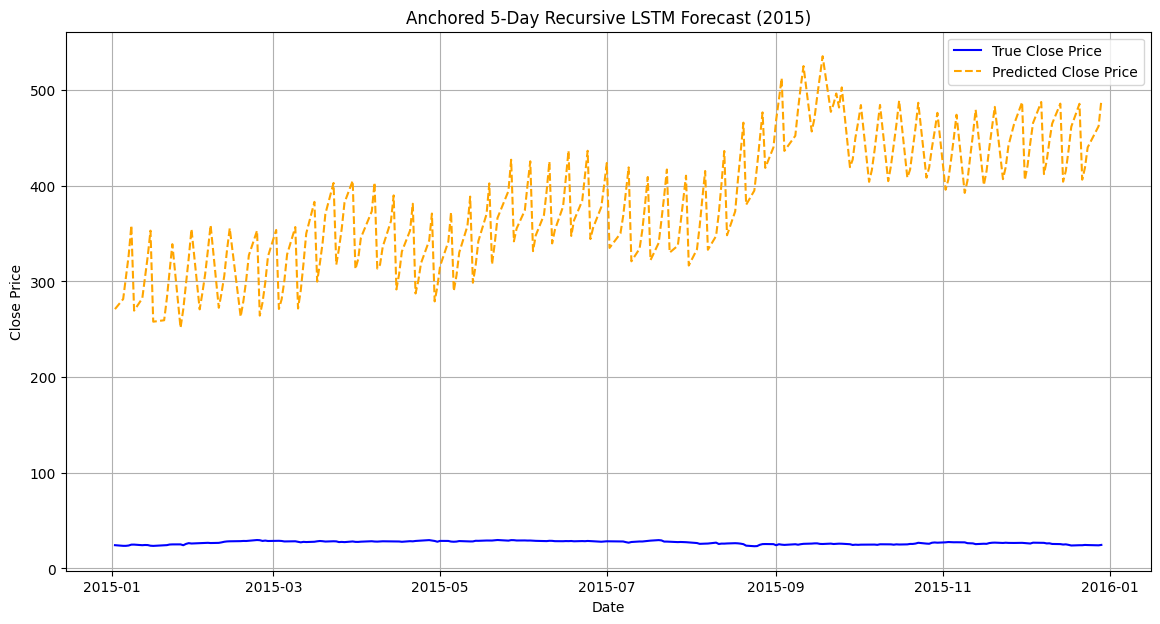

In [ ]:
# Dates for prediction
dates_all = df_cleaned.index # Use the index from the cleaned DataFrame

start_prediction_date = pd.Timestamp('2015-01-01')
end_prediction_date = pd.Timestamp('2015-12-31')

# Call the anchored prediction function
y_pred, pred_dates = anchored_recursive_predict(
    model,
    full_scaled_data,
    close_scaler,
    dates_all,
    start_prediction_date,
    end_prediction_date,
    time_steps=time_steps,
    steps=steps,
    close_idx=0
)

# Get true values for evaluation, ensuring alignment with predicted dates
y_true = df_cleaned.loc[pred_dates, 'Close'].values

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"Anchored {steps}-day recursive forecast metrics:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  R2:   {r2:.4f}")
print(f"  MAPE: {mape:.4f}")

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(pred_dates, y_true, label='True Close Price', color='blue')
plt.plot(pred_dates, y_pred, label='Predicted Close Price', color='orange', linestyle='--')
plt.title(f"Anchored {steps}-Day Recursive LSTM Forecast (2015)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()